import os
os.chdir('./02-signal_testing')# readme
分析資料種包含的各種形態瑕疵

In [1]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [2]:
from utils import xgb_model, get_data, lr_curve, eva_metric, xgb_grid_test, svm_grid_test
from noising import sig_disturb, sig_transmittion_noise, sig_drop, plt_drop

In [3]:
save_path = '03-signal_analysis'
package_path = 'water_MLOps'

In [4]:
import os
cwd = os.getcwd().split("/")[-1]
if cwd == package_path:
    print(cwd)
    if not os.path.isdir(save_path):
#         print('create '+save_path)
        os.mkdir(save_path)
    
if cwd == save_path:
    print('ok')
    pass
else:
    os.chdir(save_path)
os.getcwd()

water_MLOps


'/home/jovyan/git/water_MLOps/03-signal_analysis'

# EDA

In [5]:
df, label = get_data('~/git/water_MLOps/Cost-B.xlsx')
print(label.head())
df.head()

0    70.0
1    70.0
2    70.0
3    71.0
4    71.0
Name: dirt, dtype: float64


,C,D,time
0,17.000000,118.000000,0
1,114.680482,171.433735,1
2,287.000000,208.000000,2
3,17.000000,118.000000,3
4,123.428571,184.785714,4


In [19]:
col[60:120]

60       4.999950
61       4.999950
62       4.999950
63       7.000000
64      27.586800
65      42.000000
66      18.333150
67      18.333150
68      18.333150
69      12.000000
70       7.000000
71       9.500000
72      22.000000
73     166.400000
74     217.000000
75      11.670000
76     203.819647
77     332.000000
78     117.000000
79     223.055901
80     332.000000
81       4.999950
82       4.999950
83       4.999950
84       5.000000
85     239.476190
86     302.000000
87       4.999950
88       4.999950
89       4.999950
90      17.000000
91     222.979381
92     332.000000
93       5.830000
94     240.130714
95     287.000000
96       7.000000
97     158.000000
98     262.000000
99       7.000000
100     11.230769
101     17.000000
102      6.666600
103      6.666600
104      6.666600
105     22.000000
106     32.000000
107     42.000000
108      6.670000
109     27.778333
110     42.000000
111     12.000000
112      7.000000
113      9.500000
114      6.666600
115      6

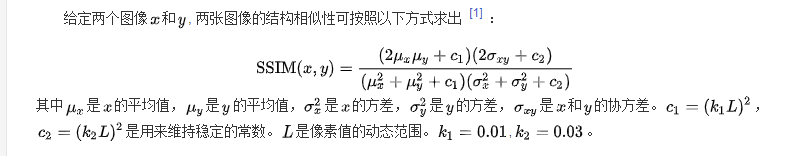

In [87]:
import numpy as np

def SSIM(x, y, k1=0.01, k2=0.03, paraL=None):
    k1 = k1
    k2 = k2
    covxy = np.cov(x, y)
    meanx = np.mean(x)
    stdx = np.std(x)

    meany = np.mean(y)
    stdy = np.std(y)

    mu1_sq = meanx ** 2
    mu2_sq = meany ** 2
    mu1_mu2 = meanx * meany
    sigma12 = covxy
    sigma1_sq = stdx ** 2 
    sigma2_sq = stdy ** 2 
    if paraL:
        L = paraL
    else:
        L = max(max(x), max(y))

    C1 = (k1*L)**2
    C2 = (k2*L)**2
    ssim =  ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                                (sigma1_sq + sigma2_sq + C2))
    ssim = np.mean(ssim)
    return(ssim)

In [89]:
x = [-2.1, -1,  4.3]
y = [3,  1.1,  0.12]

SSIM(x, y)

0.15125302536867996

In [90]:
col = df.loc[:,'C']

split = 5
lis = []

for i in range(split):
  
    a = i*len(col)//split
    b = (i+1)*len(col)//split
  
    name = 'part_'+str(i)
    lis.append(col[a:b].values)

### 鄰居overlap

In [128]:
# over lap
import numpy as np
def split_series(col, split, overlap=0.3):
    split = split
    lis = []
    overlap = overlap
    size = int(np.floor((len(col)//split)*(1+overlap)))
#     print(size)
    for i in range(split):
        a = i*len(col)//split
        b = a + size
#         print(a,b)
        if b <= len(col):
            lis.append(col[a:b].values)
        else:
            pass
    return lis


In [137]:
col = df.loc[:,'C']
z = split_series(col, 4, 0)
np.shape(z)

(3, 39)

### 計算鄰居的SSIM

In [133]:
# neighbor
target = z
for i in range(len(target)-1):
#     for _ in range()
#     print(i)
    a = target[i]

    b = target[i+1]
    print(i, i+1)
    print(SSIM(a, b))
    print('----')
#     a = SSIM(target[i], target[i+1], 0.01, 0.03)
#     print(a)

0 1
0.4463475956294221
----
1 2
0.45879316055922836
----
2 3
0.4614226137620242
----
3 4
0.48210132907935144
----


### 計算所有區塊相互的SSIM

In [134]:
# all
target = z
for i in range(len(target)):
#     for _ in range()
#     print(i)
    a = target[i]
    for _ in range(i+1, len(target)):
        b = target[_]
        print(i, _)
        print(SSIM(a, b))
    print('----')
#     a = SSIM(target[i], target[i+1], 0.01, 0.03)
#     print(a)

0 1
0.4463475956294221
0 2
0.3429894451389277
0 3
0.5911040530094083
0 4
0.3536896398039976
----
1 2
0.45879316055922836
1 3
0.259143449447073
1 4
0.5790325876766098
----
2 3
0.4614226137620242
2 4
0.4729424131976622
----
3 4
0.48210132907935144
----
----
